In [ ]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
import torch
import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from transformers import Trainer, TrainingArguments
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
reviewdf= pd.read_csv("/content/drive/MyDrive/good_full_reviews_dataset.csv")

In [ ]:
reviewdf['review'] = reviewdf['review'].astype(str)

In [ ]:
reviewdf['word_count'] = reviewdf['review'].str.split().str.len()
reviewdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26652 entries, 0 to 26651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             26652 non-null  int64 
 1   review         26652 non-null  object
 2   review_rating  26652 non-null  int64 
 3   word_count     26652 non-null  int64 
 4   sentiment      26652 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.0+ MB


In [ ]:
!pip install -U transformers

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

In [ ]:
sentimodel=pipeline("text-classification", model=model, tokenizer=tokenizer)

In [ ]:
import torch

MAX_LENGTH = 512

def sentimodel(text):
    # Tokenize full text WITH special tokens, no truncation
    tokens = tokenizer.encode(text, add_special_tokens=True)

    # Split tokens into chunks of MAX_LENGTH
    chunks = [tokens[i:i + MAX_LENGTH] for i in range(0, len(tokens), MAX_LENGTH)]

    outputs = []
    with torch.no_grad():
        for chunk in chunks:
            input_ids = torch.tensor([chunk])
            logits = model(input_ids).logits
            outputs.append(logits)

    # Average logits across chunks
    final_logits = torch.mean(torch.stack(outputs), dim=0)
    prediction_id = torch.argmax(final_logits, dim=1).item()
    label = model.config.id2label[prediction_id]

    return label


In [ ]:
reviewdf['sentiment'] = reviewdf['review'].apply(sentimodel)


In [ ]:
# Save DataFrame to CSV file
reviewdf.to_csv("good_full_reviews_dataset.csv", index=False)


In [ ]:
from google.colab import files
files.download("good_full_reviews_dataset.csv")  # or .csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Amount of review for each star rating')

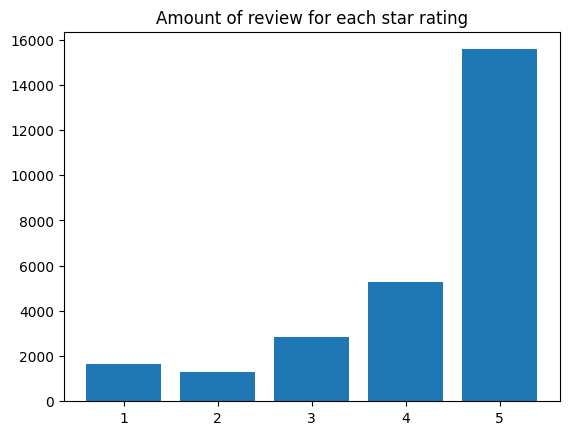

In [ ]:
review_counts = reviewdf['review_rating'].value_counts().sort_index()
plt.bar(review_counts.index, review_counts.values)
plt.title("Amount of review for each star rating")

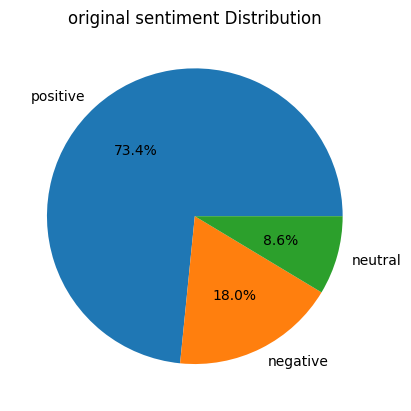

In [ ]:
plt.pie(reviewdf['sentiment'].value_counts().values,
        labels=reviewdf['sentiment'].value_counts().index,
        autopct='%1.1f%%')
plt.title("original sentiment Distribution")
plt.show()

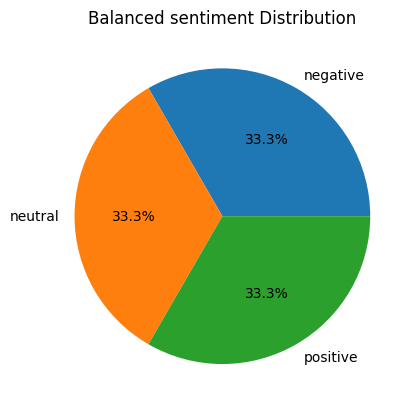

In [ ]:
star1 = reviewdf[reviewdf['sentiment'] == "negative"].sample(n=2000, random_state=42)
star2 = reviewdf[reviewdf['sentiment'] == "neutral"].sample(n=2000, random_state=42)
star3 = reviewdf[reviewdf['sentiment'] == "positive"].sample(n=2000, random_state=42)

balanced_df = pd.concat([star1, star2, star3], axis=0)

# Visualize the balanced distribution
plt.pie(balanced_df['sentiment'].value_counts().values,
        labels=balanced_df['sentiment'].value_counts().index,
        autopct='%1.1f%%')
plt.title("Balanced sentiment Distribution")
plt.show()

In [ ]:

import string
balanced_df['review'] = balanced_df['review'].str.lower()

punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_df['review']= balanced_df['review'].apply(lambda x: remove_punctuations(x))
balanced_df.head()

,id,review,review_rating,word_count,sentiment
3782,3783,dont know what made me think aion was going to...,1,73,negative
5590,5591,spirit tracks is a game more concerned with be...,2,100,negative
9805,9806,if you have watched the movie then you know ho...,1,129,negative
4590,4591,this game was a version that i never played in...,5,20,negative
10948,10949,ok so basically they just rehashed the same ga...,2,84,negative


In [ ]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(words)

balanced_df['review'] = balanced_df['review'].apply(preprocess_text)

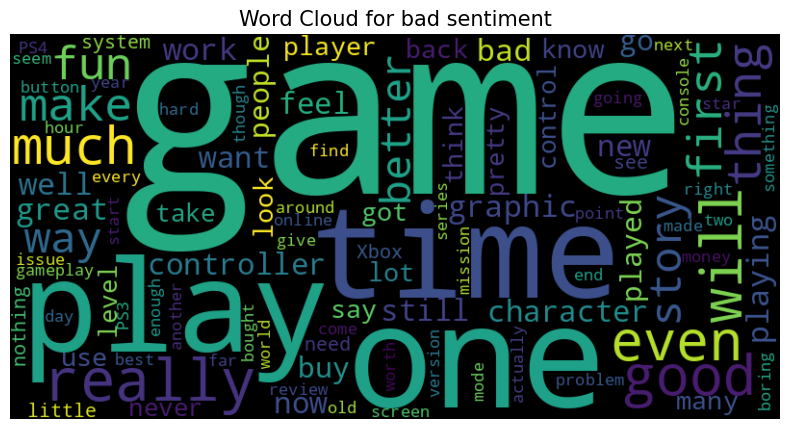

In [ ]:
def plot_word_cloud(data, typ):
    corpus = " ".join(data['review'])
    wc = WordCloud(max_words=100, width=800, height=400, collocations=False).generate(corpus)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {typ} sentiment", fontsize=15)
    plt.show()

plot_word_cloud(reviewdf[reviewdf['sentiment'] == "negative"], typ="bad")

In [ ]:
features = balanced_df['review']
target = balanced_df['sentiment']
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# One-hot encode the labels
Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)

# Tokenization
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers,regularizers

max_words = 10000
max_len = 100
#model overfitting very badly for now
model = keras.models.Sequential([
    layers.Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    layers.Bidirectional(layers.LSTM(32, dropout=0.3, recurrent_dropout=0.3)),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.build(input_shape=(None, max_len))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 100, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 751,619 (2.87 MB)

 Trainable params: 751,619 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

In [ ]:
history = model.fit(X_train_padded, Y_train,
                    validation_data=(X_val_padded, Y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[es, lr])

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 122s 747ms/step - accuracy: 0.4019 - loss: 0.6541 - val_accuracy: 0.4642 - val_loss: 0.5984 - learning_rate: 0.0010
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 141s 740ms/step - accuracy: 0.5694 - loss: 0.5533 - val_accuracy: 0.6108 - val_loss: 0.5158 - learning_rate: 0.0010
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 110s 736ms/step - accuracy: 0.7248 - loss: 0.4132 - val_accuracy: 0.6217 - val_loss: 0.5111 - learning_rate: 0.0010
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 141s 728ms/step - accuracy: 0.8298 - loss: 0.3039 - val_accuracy: 0.6275 - val_loss: 0.5782 - learning_rate: 0.0010
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 142s 731ms/step - accuracy: 0.8690 - loss: 0.2363 - val_accuracy: 0.6167 - val_loss: 0.6585 - learning_rate: 0.0010
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 144s 746ms/step - accuracy: 0.9218 - loss: 0.1600 - val_accuracy: 0.6167 - val_loss: 0.7368 - learning_rate: 5.0000e-04
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 110s 733ms/step - ac

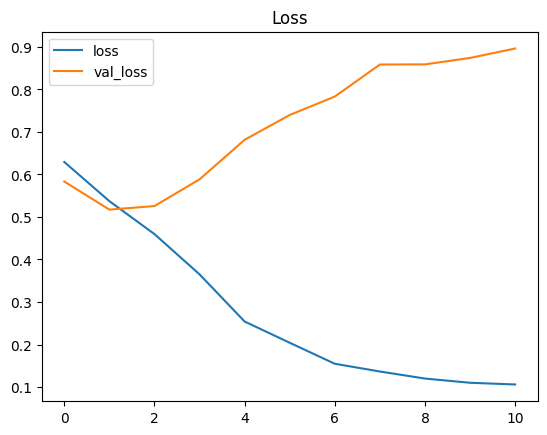

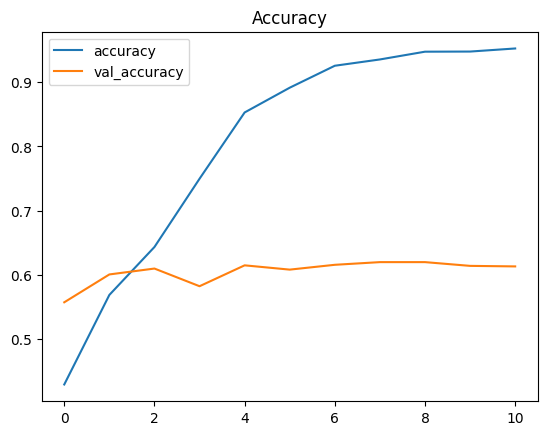

In [ ]:
history_df = pd.DataFrame(history.history)

history_df[['loss', 'val_loss']].plot(title="Loss")

history_df[['accuracy', 'val_accuracy']].plot(title="Accuracy")
plt.show()

In [ ]:
history_df.head()

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.429583,0.629337,0.557500,0.583429,0.0010
1,0.568958,0.537284,0.600833,0.517299,0.0010
2,0.643542,0.459778,0.610000,0.525668,0.0010
3,0.749792,0.365015,0.582500,0.588517,0.0010
4,0.852917,0.254130,0.615000,0.681519,0.0005


In [ ]:
test_loss, test_acc = model.evaluate(X_val_padded, Y_val)
print(f"Validation Accuracy: {test_acc:.2f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.6165 - loss: 0.8918
Validation Accuracy: 0.62


get prediction acc for diff sentiment, add data visualization(e.g. key word freq, pie chart) add sugg for future resesarch, add more graph, get heat graph of most common word to sentiment, could do clustering and tf-idf


In [ ]:
from sklearn.metrics import classification_report

import numpy as np


Y_probs = model.predict(X_val_padded)

Y_pred = np.argmax(Y_pred_probs, axis=1)

Y_true = np.argmax(Y_val.values, axis=1)

class_names = ['negative', 'neutral', 'positive']

print(classification_report(Y_true, Y_pred, target_names=class_names))


38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 534ms/step
              precision    recall  f1-score   support

    negative       0.65      0.54      0.59       437
     neutral       0.55      0.62      0.58       380
    positive       0.67      0.71      0.69       383

    accuracy                           0.62      1200
   macro avg       0.62      0.62      0.62      1200
weighted avg       0.62      0.62      0.62      1200



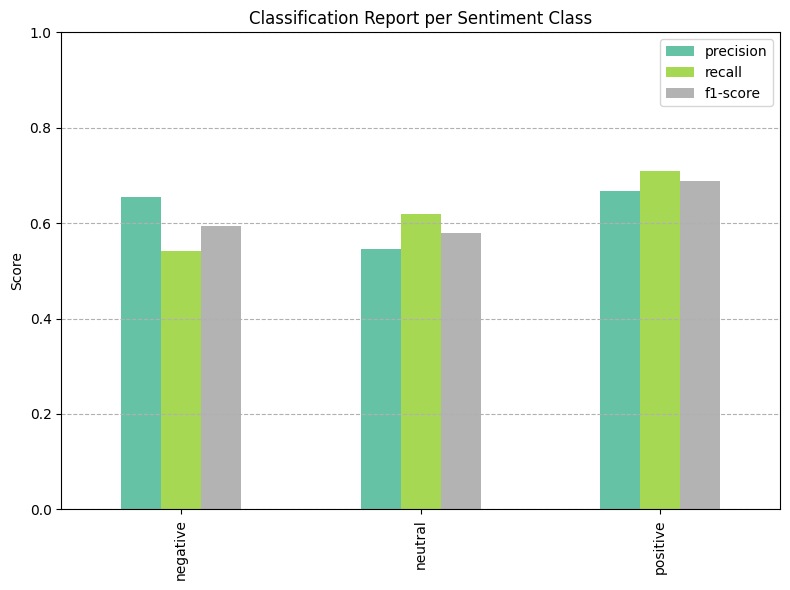

In [ ]:

df_report = pd.DataFrame(report).transpose()

df_scores = df_report.loc[class_names, ['precision', 'recall', 'f1-score']]

df_scores.plot(kind='bar', figsize=(8, 6), ylim=(0, 1), colormap='Set2')
plt.title('Classification Report per Sentiment Class')
plt.ylabel('Score')
plt.legend()
plt.grid(axis="y", linestyle="--")
plt.tight_layout()
plt.show()